In [1]:
#some qiskit libraries are being deprecated but I'm too lazy to care so I 
#just ignore all the warnings. Not good programming practice but physics!
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

import math
import random

from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua import QuantumInstance
from qiskit.providers.aer.noise import thermal_relaxation_error, ReadoutError, depolarizing_error

# provider = IBMQ.get_provider(hub='ibm-q')
# machine = provider.get_backend('ibmq_valencia')
from qiskit.test.mock import FakeLondon
machine = FakeLondon()
machine_noise_model = NoiseModel.from_backend(machine)
simulator = Aer.get_backend('qasm_simulator')


basis_gates = machine_noise_model.basis_gates

#### for starters, lets copy some functions from qiskit to get circuit for hydrogen

ignore highilighted red messages

# Important Functions for VQE

1. Hammifier

The so called VQE circuit above is just the parameterized UCCSD state. To measure the associated energy, we have to evalute the expectation value of each of 5 local hamiltonians-- II, IZ, ZI, ZZ and XX. For the first 4, we don't really have to add any gates because quantum circuits in qiskit measure in Z/I basis by default. Only for the last one do we have to add extra gates into the circuit.

2. Count to Eigenvalue

After running a job, we recieve bit strings and their frequencies. To measure expectation value of a local hamiltonian, we have to first find eigenvalues corresponding to those bit strings(eigenstates). Note the 

3. Sample Expectation Value

(A better name should be SampleEnergy)

To calculate energy value, one possible way is to compute expectation value of each local hamiltonian and then combine all those results. I DO NOT use that approach. Instead, the following function assumes that we measure 1 shot for each local hamiltonian, combine the results to get a sample of energy and repeat 1024 times. At the end we will average over all the samples of energy to get the true energy/expectation value.


4. ExpecValforSamples

This is parent function of #3. Now this function recieves 1024 shots for each local hamiltonian circuit. To get 1 sample for each local hamiltonian for the above function, we simply pick a random shot from the 1024 shots for each local hamiltonian and then send that to the above function. (Note there are only 2 circuits even though there are 5 local hamiltonians. Why so? refer to #1)

In [8]:
def expecValForSamples(counts_zsis, counts_xx, Hamiltonian, hammy_weights):
    '''
    Input: counts [dict] for zz,iz, etc. , counts[dict] for xx
    Output: List of expecVal for all the samples
    '''
    
    #convert dict to list
    list_zsis = dictToList(counts_zsis)
    list_xx = dictToList(counts_xx)
    
    #extract samples from list and compute expec val
    expec_vals = []
    while(len(list_zsis)!= 0 and len(list_xx)!= 0): 
        index1 = random.randrange(0, len(list_zsis))
        index2 = random.randrange(0, len(list_xx))
        
        exp_val= sampleExpecVal(list_zsis[index1], list_xx[index2], Hamiltonian, hammy_weights)
        expec_vals.append(exp_val)
        
        #removing those items from list 
        list_zsis.pop(index1)
        list_xx.pop(index2)
    return expec_vals

5. Evaluator

This is a big function trying to do a lot of things at once.

1. This function recieves multiple circuits, each of them corresponds to a local hamiltonian (in H2, there are only 2 such circs)

2. Because we can only do 8192 shots at a time and we may need more than that for statistics, this function takes the argument samples(bad name-- this should be called shots) and until we get that many samples, we "while-loop" over and over again.Now each job returns a dictionary of results (bit strings as keys and their frequencies as values) and we need to add all dicts so that it seems we have gottten , say, 90K shots at once.

In [9]:
def evaluator(circuits, samples, noise_model, Hamiltonian, hammy_weights, simulator):
    """
    Input: circuits, noise model to run on , weights of the local hammys
    Output: expectation value (energy)
    
    """
    
    #Running the circuits 
    results = [[] for i in range(len(circuits))]
  
    
    
    while(samples!=0):
        if (samples>8192):
            for i_circ in range(len(circuits)):
                circ = circuits[i_circ]
                if(noise_model!=None):
                    job =  execute(circ, backend = simulator, noise_model = noise_model, shots = 8192)
                else:
                    job = execute(circ, backend = simulator, shots = 8192)
                counts = job.result().get_counts()
                results[i_circ].append(counts)
            samples-= 8192
        else: 
            for i_circ in range(len(circuits)):
                circ = circuits[i_circ]
                if(noise_model!=None):
                    job =  execute(circ, backend = simulator, noise_model = noise_model, shots = samples)
                else:
                    job = execute(circ, backend = simulator, shots =samples)
                counts = job.result().get_counts()
                results[i_circ].append(counts)
            samples = 0
    #print('Running Circuits done')
    #adding up all the dicts
    counties = [addDicts(circ_results) for circ_results in results]
    
    #print('Adding dicts done')
    #computing expectation values
    expec_vals = expecValForSamples(counties[0], counties[1], Hamiltonian, hammy_weights)
    #print('Computing expec vals done')
    
    mean = np.mean(expec_vals)
    #std = np.std(expec_vals)
        
    return mean

6. Helper functions

These functions are auxiliary-- they perform little tasks for big functions. (I did not want to make big functions even more bigger so thats why we have the these small functions).

The most important out of these is dictToList. Its best shown through an example. Suppose I got the following dict after running a job {'00': 1, '01':2, '10':3, '11':4}. In response, this function converts that dictionary into a list ['00', '01', '01', '10', '10', '10', '11', '11', '11', '11'] This is required for #4.

In [10]:
def binaryToDecimal(binary):  
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal

def dictToList(dicty): 
    '''
    Converts dictionary to a list of keys appearing [frequency] number of times
    '''
    keys = dicty.keys()
    listy = []
    
    for key in keys: 
        listy += [key for i in range(dicty[key])]
    
    return listy
def addDicts(listy): 
    '''
    Input: list of dicts of counts 
    Output: combining all dicts into one dict, returning that
    '''
    keys = ['00', '11', '10', '01']
    master = {}
    
    for key in keys: 
        #initializing master at that key
        master[key] = 0
        
        #now adding up all dictys[key]
        for dicty in listy: 
            try:
                master[key] += dicty[key]
            except KeyError: 
                continue
    return master

To not keep on defining these functions every time I open a new notebook, I can easily import them from python files which are stored in the same folder as the notebook trying to access them. That last bit is really important.

In [11]:
#Local Hamiltonian Function
from VQEHamiltonian_funcs import Hammifier

# Expectation Value/Running Functions
from Result_funcs import binaryToDecimal, dictToList, sampleExpecVal, countToEig, expecValForSamples, addDicts, evaluator

# Noise Model

Ok! another class of functions for getting the noise model. Now when you use qiskit noise model, its kind of annoying trying to isolate coherent from incoherent and so on. The following function saves us from such troubles. The most important function is generateNoiseModel ...pay attention to its arguments. Using those arguments we mix and isolate noise types.

In [12]:
'''

def generateDepolarizingError(machine, gate, qubits)

def generateRelaxationError(machine, gate, qubits, t1, t2, amp = 1, custom_t = False):
    """
    Return a relaxation error
    """

def generateNoiseModel(machine, coherent = True, incoherent = False, readout = False, custom_t = False, t1 = None, t2 = None, reverse = False):
    """
    Returns a realistic copy of london noise model with custom t1, t2 times
    """

'''

from NoiseModel import generateDepolarizingError, generateRelaxationError, generateNoiseModel

An example...meaningless by itself. use it when running a job

In [13]:
 noise_model = generateNoiseModel(machine, coherent = True, incoherent = True, readout= True)

Original: 0.01 0.050000000000000044
Reverse: 0.01 0.050000000000000044
Original: 0.02 0.07666666666666666
Reverse: 0.02 0.07666666666666666
Original: 0.14 0.18999999999999995
Reverse: 0.14 0.18999999999999995
Original: 0.0033333333333332993 0.03
Reverse: 0.0033333333333332993 0.03
Original: 0.006666666666666667 0.043333333333333335
Reverse: 0.006666666666666667 0.043333333333333335


# Running Circuits for different Param

The following functions will evaluate energy of H2 as a function of random parameters. It does so 10 times (when you run the following cell, it will print out what iteration its currently at...wait till 9) and we later plot the differences

In [14]:
counter = 0

def EnergyFinder(param):
    '''
    Input: param (1D array) for which to compute energy on VQE circ of H2
    Output: energy
    '''
    
    Hamiltonian = """II\nIZ\nZI\nZZ\nXX"""
    Hamiltonian_weights = [-1.053, 0.395, -0.395, -0.011, 0.181]
    backend = simulator
    global noise_model
    samples = 8192
    
    
    
    circ = var_form.construct_circuit(param).decompose()
    circuits = Hammifier(circ, Hamiltonian)
    noisy = evaluator(circuits, samples, noise_model, Hamiltonian, Hamiltonian_weights, simulator)
    ideal = evaluator(circuits, samples, None, Hamiltonian, Hamiltonian_weights, simulator)
    return noisy, ideal

def main():
    '''
    Choose param and compute mean
    '''
    d = -math.pi
    u = math.pi
    
    energies = []
    diff = []
    params = []
    
    for i in range(10):
        print(i)
    
        p1 = random.uniform(d, u)
        p2 = random.uniform(d, u)
        p3 = random.uniform(d, u)


        noisy, ideal = EnergyFinder([p1,p2,p3])
        energies.append([[p1,p2,p3], ideal, noisy])
        diff.append(noisy-ideal)
        
    return energies, diff
energies, diff = main()

0


C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages

1


C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages

2


C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages

3


C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages

4


C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages

5


C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages

6


C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages

7


C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages

8


C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages

9


C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages\qiskit\chemistry\components\variational_forms\uccsd.py:429: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qbits[i] = circuit.qubits[qbits[i].index]
C:\Users\Eesh Gupta\anaconda\lib\site-packages

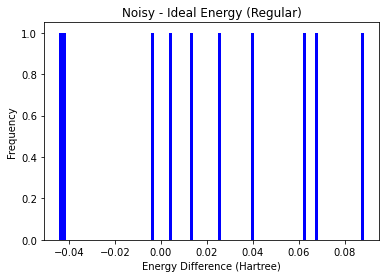

In [15]:
import numpy as np
import matplotlib.pyplot as plt

a = plt.figure()
plt.hist(diff, bins=100, color = "blue")
plt.title("Noisy - Ideal Energy (Regular)")
plt.xlabel("Energy Difference (Hartree)")
plt.ylabel("Frequency")
plt.show()
#a.savefig('Normal(1).png', dpi = 1000)